In [109]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd
import instrument
from portfolio import Portfolio
from risk_parity import RiskParity
from copy import copy, deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data\\"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])
exps = pd.read_csv('data\\ETF_info.csv', index_col=0).loc[env_df[['EQ', 'EM', 'RE', 'FI']].columns.droplevel(), 'Expense Ratio'].astype(float)
data = HistoricalData(env_df, features_df, targets_df)

date = Timestamp('2009-03-01') + MonthEnd(0)
date_end = date + MonthEnd(62)
env_now = Environment(*data.get_env_args(date))
rp = RiskParity(data)


### Initializing stuff

In [111]:
def dumb_optimize(env: Environment):
    w_dict = {}
    n_assets = len(env.prices.items())
    for asset, price in env.prices.items():
        w_dict[asset] = 1/n_assets
    return w_dict

usd = 200000/env_now.fx['CAD']
w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
# w_dict = dumb_optimize(env_now)
pos_dict = Portfolio.weights_to_pos(w_dict, env_now, usd)
pos_dict = Portfolio.etf_dict_from_names(pos_dict)
icash = instrument.Cash('USD')
pos_dict[icash] = 0

In [112]:
my_pf = Portfolio(pos_dict)
etf_w = 0.99
etf_total_val= my_pf.calc_value(env_now)*etf_w
opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)

my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps, time_past=0)


C = 1 + 0.02
K1 = C - 0.03
K2 = C
K3 = C + 0.03
ttm=2

specs = [{'name':'SPY Call 1', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 2', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 3', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'}
         ]

cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
nopt = opt_total_val/cost
ofee = my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)

last_pf_val = my_pf.calc_value(env_now)
last_etf_val = my_pf.get_eq_value(env_now)

last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)

last_opt_val = my_pf.get_options_value(env_now)



### Set up performance df

In [113]:
perf_df = pd.DataFrame(index = pd.date_range(start=date, end=date_end, freq='M'))
perf_df['USD Value'] = 0
perf_df['CAD Value'] = 0
perf_df['PNL'] = 0
perf_df['Post-fee PNL'] = np.nan
perf_df['ETF PNL'] = np.nan

perf_df['EQ PNL'] = np.nan
perf_df['FI PNL'] = np.nan
perf_df['EM PNL'] = np.nan
perf_df['RE PNL'] = np.nan

perf_df['Option PNL'] = np.nan
perf_df['Delta PNL'] = np.nan
perf_df['Vega PNL'] = np.nan
perf_df['Theta PNL'] = np.nan
perf_df['Rho PNL'] = np.nan
perf_df['Unexplained PNL'] = np.nan

perf_df['Return'] = 0
perf_df['Post-fee Return'] = np.nan
perf_df['ETF Return'] = np.nan

perf_df['EQ Return'] = np.nan
perf_df['FI Return'] = np.nan
perf_df['EM Return'] = np.nan
perf_df['RE Return'] = np.nan

perf_df['Option Return'] = np.nan
perf_df['Delta Return'] = np.nan
perf_df['Vega Return'] = np.nan
perf_df['Theta Return'] = np.nan
perf_df['Rho Return'] = np.nan
perf_df['Unexplained Return'] = np.nan

perf_df['Injection'] = 0
perf_df['FX'] = env_now.fx['CAD']
perf_df['Option Fees'] = ofee
perf_df['ETF Fees'] = 0
perf_df['ETF Expenses'] = 0

perf_df['Total Fees'] = 0
perf_df['Percentage Fees'] = 0



### Run sim/backtest

In [114]:
perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
perf_df.loc[date, 'Return'] = np.nan
perf_df.loc[date, 'PNL'] = np.nan

while date < date_end:
    
    date = date + MonthEnd(1)
    env_before = deepcopy(env_now)
    env_now = Environment(*data.get_env_args(date))
    
    if env_now.surfaces['SPY US Equity'].matrix[1,5] > 0.20:
        # print(date, ": high vol of {:.2f}".format(env_now.surfaces['SPY US Equity'].matrix[1,5]))
        etf_w = 0.99
    else:
        etf_w = 0.99
    
    new_pf_val = my_pf.calc_value(env_now)
    new_etf_val = my_pf.get_eq_value(env_now)
    new_opt_val = my_pf.get_options_value(env_now)
    new_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    new_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    new_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    new_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
    
    
    etf_total_val= my_pf.calc_value(env_now)*etf_w
    opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)
    

    perf_df.loc[date, 'FX'] = env_now.fx['CAD']
    
    if (date.month == 8) or (date.month == 2):
        my_pf.pf_units[my_pf.get_cash('USD')] += 20000/env_now.fx['CAD']
        perf_df.loc[date, 'Injection'] = 20000/env_now.fx['CAD']
        
    
    
    perf_df.loc[date, 'PNL'] = new_pf_val - last_pf_val
    perf_df.loc[date, 'ETF PNL'] = new_etf_val - last_etf_val
    perf_df.loc[date, 'Option PNL'] = new_opt_val - last_opt_val
    
    attribs = my_pf.get_pnl_attr(env_before, env_now)
    perf_df.loc[date, 'Delta PNL'] = attribs['delta']
    perf_df.loc[date, 'Vega PNL'] = attribs['vega']
    perf_df.loc[date, 'Theta PNL'] = attribs['theta']
    perf_df.loc[date, 'Rho PNL'] = attribs['rho']
    perf_df.loc[date, 'Unexplained PNL'] = perf_df.loc[date, 'Option PNL'] -\
            attribs['delta'] - attribs['vega'] - attribs['theta'] - attribs['rho']
    
    perf_df.loc[date, 'EQ PNL'] = new_eq_val - last_eq_val
    perf_df.loc[date, 'FI PNL'] = new_fi_val - last_fi_val
    perf_df.loc[date, 'EM PNL'] = new_em_val - last_em_val
    perf_df.loc[date, 'RE PNL'] = new_re_val - last_re_val
    
    perf_df.loc[date, 'Return'] = (new_pf_val - last_pf_val)/last_pf_val
    perf_df.loc[date, 'ETF Return'] = (new_etf_val - last_etf_val)/last_pf_val
    perf_df.loc[date, 'Option Return'] = (new_opt_val - last_opt_val)/last_pf_val
    perf_df.loc[date, 'Delta Return'] = attribs['delta']/last_pf_val
    perf_df.loc[date, 'Vega Return'] = attribs['vega']/last_pf_val
    perf_df.loc[date, 'Theta Return'] = attribs['theta']/last_pf_val
    perf_df.loc[date, 'Rho Return'] = attribs['rho']/last_pf_val
    perf_df.loc[date, 'Unexplained Return'] = perf_df.loc[date, 'Unexplained PNL']/last_pf_val
    
    perf_df.loc[date, 'EQ Return'] = (new_eq_val - last_eq_val)/last_pf_val
    perf_df.loc[date, 'FI Return'] = (new_fi_val - last_fi_val)/last_pf_val
    perf_df.loc[date, 'EM Return'] = (new_em_val - last_em_val)/last_pf_val
    perf_df.loc[date, 'RE Return'] = (new_re_val - last_re_val)/last_pf_val
    
    
    efee, eexps = my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps)
    ofee = my_pf.sell_options(env_now)
    
    # re-buy options
    
    cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
    nopt = opt_total_val/cost    
    ofee += my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)
    
    # record post-rebalancing (next month starting) portf value
    perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
    perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
    perf_df.loc[date, 'Post-fee Return'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'])/perf_df.loc[date + MonthEnd(-1), 'USD Value'] - 1
    perf_df.loc[date, 'Post-fee PNL'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection']) - perf_df.loc[date + MonthEnd(-1), 'USD Value']
    
    # record fees
    perf_df.loc[date, 'ETF Fees'] = efee
    perf_df.loc[date, 'ETF Expenses'] = eexps
    perf_df.loc[date, 'Option Fees'] = ofee
    perf_df.loc[date, 'Total Fees'] = ofee + eexps + efee
    perf_df.loc[date, 'Percentage Fees'] = (ofee + eexps + efee)/last_pf_val
    
    # find post fee returns
    
    
    # record post rebalancing values for opts and eqs
    last_pf_val = my_pf.calc_value(env_now)
    last_etf_val = my_pf.get_eq_value(env_now)
    last_opt_val = my_pf.get_options_value(env_now)
    last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    #####
    # my_pf.get_forw_risk(env_now: Environment, dist: Distribution, N=1000) vector of 1000 simulated forward pnls
    # -> self.emp_dist = xxxx
    # -> my_pf.calc_var()
    # -->   return -np.percentile(self.emp_dist, 5)
    # -> my_pf.calc_cvar()
    
    
    #####
    

In [115]:
my_pf.get_options()[0].get_greeks(env_now)

{'delta': 0.5711319481309044,
 'gamma': 0.03915559501059838,
 'vega': 37.84053632431412,
 'theta': -9.102795433392478,
 'rho': 21.795400347520232}

In [118]:
sub_df = perf_df[['Option PNL', 'Delta PNL', 'Vega PNL', 'Theta PNL', 'Rho PNL', 'Unexplained PNL']]
sub_df


,Option PNL,Delta PNL,Vega PNL,Theta PNL,Rho PNL,Unexplained PNL
2009-03-31,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,1052.229834,240.779660,636.396833,300.403090,0.147375,-125.497124
2009-05-31,-2243.307412,-22.857417,-2081.777876,-537.192134,0.001882,398.518133
2009-06-30,582.162316,-5.913801,48.724633,336.485513,-0.606974,203.472945
2009-07-31,1067.353455,526.551577,608.223818,344.676583,0.000000,-412.098523
2009-08-31,1464.935094,287.644882,433.498072,338.615895,-0.138913,405.315159
2009-09-30,1672.219822,299.226398,486.475715,351.939677,-0.437257,535.015289
2009-10-31,-97.338186,-290.080857,-282.713154,415.593690,0.000000,59.862135
2009-11-30,2088.883062,545.762774,1141.184362,401.870876,0.000000,0.065051
2009-12-31,2168.247368,261.391373,802.974966,406.558687,-0.223128,697.545470


### Evaluate performance

In [106]:
irr_values = np.array([-perf_df['USD Value'].iloc[0]] + (-perf_df['Injection'].values).tolist())
irr_values[-1] += perf_df['USD Value'].iloc[-1]
np.irr(irr_values)*12

0.13578292999722308

In [8]:
ret_vec =  perf_df['Return'].dropna().values
ret_vec = perf_df['Option Return'].dropna().values


m = ret_vec.mean()*12
s = ret_vec.std()*np.sqrt(12)
var = -np.percentile(ret_vec, 5)*np.sqrt(12)
cvar = -ret_vec[ret_vec<np.percentile(ret_vec, 5)].mean()*np.sqrt(12)
print("Mean: {:.1f}%\nStd: {:.1f}%\nVaR: {:.1f}%\nCVaR: {:.1f}%".format(m*100, s*100, var*100, cvar*100))
print("Sharpe: {:.1f}".format(m/s))

Mean: 6.2%
Std: 2.5%
VaR: 1.7%
CVaR: 2.1%
Sharpe: 2.4


In [9]:
import matplotlib.pyplot as plt
perf_df['Return'].dropna().hist()
plt.show()

<Figure size 640x480 with 1 Axes>

In [10]:
print(perf_df['ETF Return'].std()*np.sqrt(12))
print(perf_df['ETF Return'].mean()*12)

0.05774635645148821
0.08659707192278318


In [11]:
print(perf_df['Option Return'].std()*np.sqrt(12))
print(perf_df['Option Return'].mean()*12)

0.02548753497391058
0.06184584895467727


### Risk stuff for current portfolio

In [12]:
my_pf.get_forward_pnl(env_now, data, 1000)
my_pf.calc_var()

19804.82273474072

(array([ 14.,  38.,  84., 127., 198., 203., 212.,  84.,  31.,   9.]),
 array([-35371.73087072, -27506.69222758, -19641.65358443, -11776.61494129,
         -3911.57629815,   3953.46234499,  11818.50098814,  19683.53963128,
         27548.57827442,  35413.61691757,  43278.65556071]),
 <a list of 10 Patch objects>)

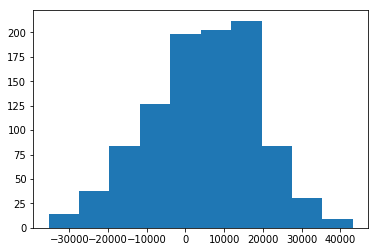

In [13]:
plt.hist(my_pf.emp_dist)

In [14]:
(perf_df['PNL'] * my_pf.calc_value(env_now) / perf_df['USD Value']).sort_values()

2013-05-31   -18165.060767
2013-06-30   -17459.058485
2013-08-31   -14100.156018
2009-12-31   -10025.277600
2010-05-31    -7707.519990
2010-11-30    -5997.685994
2011-06-30    -5972.848540
2011-11-30    -5149.960309
2011-09-30    -4723.541364
2010-01-31    -4597.734879
2009-10-31    -3917.910317
2013-11-30    -1729.669546
2012-10-31    -1388.122122
2012-05-31    -1204.460934
2011-08-31     -374.708276
2010-12-31     1713.774879
2013-12-31     1943.087620
2011-03-31     3113.295274
2012-03-31     3596.963530
2009-06-30     3882.455285
2014-01-31     4217.854462
2013-07-31     4360.279928
2013-02-28     5030.127776
2011-05-31     5268.212655
2011-01-31     5549.551895
2010-02-28     5657.887997
2012-08-31     5904.800445
2014-03-31     5942.285206
2011-07-31     6456.149093
2012-11-30     6522.163235
                  ...     
2012-04-30     7332.099339
2012-09-30     7454.655015
2010-09-30     8703.961645
2011-12-31     9730.356933
2012-02-29    10118.815642
2010-08-31    10249.929206
2

In [15]:
greeks = my_pf.calc_opt_greeks(env_now)

In [16]:
print(greeks['delta']*env_now.prices['SPY US Equity']*0.01)
print(0.5*greeks['gamma']*(env_now.prices['SPY US Equity']*0.01)**2)
print(greeks['vega']*0.01)
print(greeks['theta']/12)

1078.9784055281957
-31.532632548395945
-270.8788417533058
1217.6467369820232
